TUMOR ANALYSIS - CUBIC MESH

This notebook is used to divide in a specific number of REV the cubic mesh network extracted for the entire tumor geometry given as input, to compute the upscaled parameters and to solve the final coupled problem.

In [1]:
import time
from scipy.sparse import *
from dolfin import *
from block import *
from xii import *
import numpy as np
import matplotlib.pyplot as plt
import auxiliary_functions as aux
from scipy.sparse.linalg import *
from petsc4py import PETSc
from scipy.spatial import Delaunay



/home/fra/miniconda3/envs/tesi2/lib/python3.11/site-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


Mesh import

In [2]:
meshQ = Mesh()

mesh_name='complex_mesh_1.9'
     
with XDMFFile(f'Tumor_mesh_cube/{mesh_name}.xdmf') as infile:

     infile.read(meshQ)
     
tol=1e-15
coord=meshQ.coordinates()
labels_V=555*np.ones(np.shape(coord)[0],)

indx=np.where(np.abs(coord[:,0]-np.min(coord[:,0]))<=tol)[0]
labels_V[indx]=111

indx=np.where(np.abs(coord[:,0]-np.max(coord[:,0]))<=tol)[0]
labels_V[indx]=999

indx=np.where(np.abs(coord[:,1]-np.min(coord[:,1]))<=tol)[0]
labels_V[indx]=111

indx=np.where(np.abs(coord[:,1]-np.max(coord[:,1]))<=tol)[0]
labels_V[indx]=999

indx=np.where(np.abs(coord[:,2]-np.min(coord[:,2]))<=tol)[0]
labels_V[indx]=111

indx=np.where(np.abs(coord[:,2]-np.max(coord[:,2]))<=tol)[0]
labels_V[indx]=999

Q_markers = MeshFunction('size_t', meshQ, 0)

Q_markers.array()[:]=labels_V

REV division process and computation of the Upscaled Parameters

In [3]:
n_div_x=2
n_div_y=2
n_div_z=2
p_in =7000
p_out=5000
min_val = 2  # Minimum value
max_val = 13 

radii=np.load(f"Tumor_mesh_cube/radii_cancer_cube_{mesh_name}.npy")

radii_not_scaled=radii*1e-6

dir_results = '/mnt/c/Users/franc/Desktop/TUMOR_CUBE_NET'


K_x,K_y,K_z,C,mu_bl_up = aux.REV_division('CapillaryMesh',dir_results,meshQ,radii_not_scaled, Q_markers,n_div_x,n_div_y,n_div_z,p_in,p_out,plot_mesh_flag=False, M_plot_flag=False,lap_plot_flag=False)


-------------------- MESH INFO --------------------
Coordinates: (6126, 3)
Edges: (7407, 2)
Radii: (7407,)
Labels: (6126,)
Interior Points: (5303,)
Inlet Points: (342,)
Outlet Points: (481,)

Total REV number: 8
770
662
1124
1008
318
322
800
1151
-------------------- COMPUTING INTERSECTIONS --------------------
Coordinates with intersections: (6449, 3)
Edges with intersections: (7730, 2)
Labels with intersections: (6449,)
Radii with intersections: (7730,)

... COMPUTING K VALUES  ...

------------------------------------------------- DIRECTION: 1  -------------------------------------------------
-------------------------------------------------------------------------
REV = 1
(987, 2)
(987,)
-------------------- SUBMESH INFO --------------------
Coordinates: (774, 3)
Edges: (916, 2)
Labels: (774,)
Inlet points submesh: 43
Outlet points submesh: 83
Number of vertices: 774
Number of cells: 916
1 x
Solving linear variational problem.
-9.865797736478436e-14
-1.1637784449690655e-13
6.04364

In [4]:
formatted_vector = ['{:.2e}'.format(value) for value in C]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)

[6.04e-06, 4.19e-06, 6.7e-06, 7.39e-06, 2.02e-06, 1.8e-06, 6.06e-06, 8.68e-06]


In [5]:
formatted_vector = ['{:.2e}'.format(value) for value in K_x]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)
formatted_vector = ['{:.2e}'.format(value) for value in K_y]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)
formatted_vector = ['{:.2e}'.format(value) for value in K_z]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)

[9.87e-14, 4.37e-14, 7e-14, 1.12e-13, 2.18e-14, 2.58e-14, 7.99e-14, 1.67e-13]
[9.5e-14, 5.38e-14, 2.66e-13, 2.04e-13, 3.96e-27, 2.42e-14, 2.77e-13, 2.36e-13]
[5.74e-14, 2.18e-14, 1.03e-13, 7.76e-14, 2.66e-14, 2.16e-14, 3.99e-14, 1.49e-13]


In [6]:
formatted_vector = ['{:.2e}'.format(value) for value in mu_bl_up]
float_vector = [float(value) for value in formatted_vector]
print(float_vector)

[0.00285, 0.00282, 0.00276, 0.00276, 0.00276, 0.00283, 0.00282, 0.00273]


Functions used to create the mesh and to build the problem

In [7]:
def get_mesh(name,n_div_x,n_div_y,n_div_z):
     ''' Function that creates the capillary and tissue meshes with respective boundary tags.
               INPUT:
                    name : name of the mesh.
                    n_div_x : number of division in the x direction.
                    n_div_y : number of division in the y direction.
                    n_div_z : number of division in the z direction.

               OUTPUT:
                    meshV : cubic mesh of the region.
                    Q_markers : markers for the capillary boundary points.
                    V_markers : markers fot the tissue boundary points.
                    REV_markets_t : REV_markers.


     '''
     #--------------------MESHES-------------------------

     #3D mesh Tissue mesh
     meshV = Mesh()

     mesh_name=name
     
     with XDMFFile(mesh_name+".xdmf") as infile:

          infile.read(meshV)
     
          
     coord_V=meshV.coordinates()

     tol=1e-5
     labels_V=555*np.ones(np.shape(coord_V)[0],)

     indx=np.where(np.abs(coord_V[:,0]-np.min(coord_V[:,0]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,0]-np.max(coord_V[:,0]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.max(coord_V[:,1]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,2]-np.max(coord_V[:,2]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.min(coord_V[:,1]))<=tol)[0]
     labels_V[indx]=111

     indx=np.where(np.abs(coord_V[:,2]-np.min(coord_V[:,2]))<=tol)[0]
     labels_V[indx]=111

     V_markers = MeshFunction('size_t', meshV, 0)

     V_markers.array()[:]=labels_V

     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/V_markers.xdmf")
     file.write(V_markers)

     REV_labels_t=aux.compute_REV_labels(meshV,n_div_x,n_div_y,n_div_z)

     REV_markers_t = MeshFunction('size_t', meshV, 0)


     #Per ogni punto della mesh del tessuto ho i tag da 1 a 8 che mi indicano a quale REV appartiene
     REV_markers_t.array()[:]=REV_labels_t
     #print(REV_labels_t)

     file2 = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/REV_markers.xdmf")
     file2.write(REV_markers_t)

     #--------------------------------------------------

     #Capillary mesh

     tol=1e-5
     labels_Q=555*np.ones(np.shape(coord_V)[0],)

     indx=np.where(np.abs(coord_V[:,0]-np.min(coord_V[:,0]))<=tol)[0]
     labels_Q[indx]=111

     indx=np.where(np.abs(coord_V[:,0]-np.max(coord_V[:,0]))<=tol)[0]
     labels_Q[indx]=999

     indx=np.where(np.abs(coord_V[:,1]-np.min(coord_V[:,1]))<=tol)[0]
     labels_Q[indx]=111

     indx=np.where(np.abs(coord_V[:,1]-np.max(coord_V[:,1]))<=tol)[0]
     labels_Q[indx]=999

     indx=np.where(np.abs(coord_V[:,2]-np.min(coord_V[:,2]))<=tol)[0]
     labels_Q[indx]=111
     
     indx=np.where(np.abs(coord_V[:,2]-np.max(coord_V[:,2]))<=tol)[0]
     labels_Q[indx]=999

     print(type(labels_Q))

     Q_markers = MeshFunction('size_t', meshV, 0)

     Q_markers.array()[:]=labels_Q

     file = XDMFFile(f"{dir_results}/FINAL_RESULTS/MARKERS/Q_markers.xdmf")
     file.write(Q_markers)

     
     coord_V=meshV.coordinates()

     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=REV_markers_t.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title("REV division markers")


     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=V_markers.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('Boundary markers for the tissue mesh')


     fig = plt.figure(figsize=(8, 6))
     ax = fig.add_subplot(111, projection='3d')
     scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=Q_markers.array())
     cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
     plt.title('Boundary markers for the capillary mesh')



     return meshV, Q_markers, V_markers, REV_markers_t

def get_system(meshV, K_x, K_y, K_z, C, mu_bl_up, beta_value,p0_value):
      ''' Function that assemble the matrices to solve the problem
          INPUT:
               meshV : mesh of the cubic geometry.
               K_x :  x components of the permeability tensor, one for each REV.
               K_y :  y components of the permeability tensor, one for each REV.
               K_z :  z components of the permeability tensor, one for each REV.
               C : RHS terms, one for each REV.
               mu_bl_up : upscaled blood viscosity terms, one for each REV.
               beta_value :  Neumann parameter fot the tissue.
               p0_value : initial reference pressure value for the tissue.
               ds : measure for the tissue.

          OUTPUT:
               AD : stiffness matrix.
               M : mass matrix.
               b : RHS term
               W : space of the solutions.
               T : total matrix.
      
      '''
      #"""A, b, W, bcs"""


      # Spaces
      nRev=8
      #Q = FunctionSpace(meshQ, 'CG', 1)
      V = FunctionSpace(meshV, 'CG', 1)

      W = (V, V)

      pcap, pt = map(TrialFunction, W)
      qcap, qt= map(TestFunction, W)

      #----------------------------------------------------------
     
      #Parameters

      rho_bl = Constant(1030) #kg/m^3
      rho_int = Constant(1000) #kg/m^3
      mu_int= Constant(1.3*1e-3) #Pa * s
      k_t = Constant(1e-18) #m^2
      K_T=Constant(rho_int*k_t/mu_int)

      pi_p = Constant(3300)
      pi_int = Constant(666)
      p0 = Constant(p0_value)

      scaling=Constant(1)
      
      beta = Constant(beta_value)

      
      #-------------------------------------------------------------------

      class K(UserExpression):

        def __init__(self, mesh, REV_division, nRev, K_x, K_y, K_z, mu_bl_up,**kwargs):
                super().__init__()
                self.REV_division = REV_division
                self.nRev=nRev
                self.K_x = K_x
                self.K_y = K_y
                self.K_z = K_z
                self.mu_bl_up_x = mu_bl_up
                self.mu_bl_up_y = mu_bl_up
                self.mu_bl_up_z = mu_bl_up
                self.mesh=mesh

        def value_shape(self):
            return (3, 3)

        def eval(self, values, x):
            "Set value[0] to value at point x"
            tol = 1E-14
            for REV in range(self.nRev):

                xmin=self.REV_division[REV+1]['xmin']
                xmax=self.REV_division[REV+1]['xmax']
                ymin=self.REV_division[REV+1]['ymin']
                ymax=self.REV_division[REV+1]['ymax']
                zmin=self.REV_division[REV+1]['zmin']
                zmax=self.REV_division[REV+1]['zmax']
            
                if (((x[0]-xmin)>=-tol) and ((x[0]-xmax)<=tol) and ((x[1]-ymin)>=-tol) and ((x[1]-ymax)<=tol) and ((x[2]-zmin)>=-tol) and ((x[2]-zmax)<=tol)):
                    values[0] = self.K_x[REV] / self.mu_bl_up_x[REV]
                    values[1] = 0
                    values[2] = 0
                    values[3] = 0
                    values[4] = self.K_y[REV] / self.mu_bl_up_y[REV]
                    values[5] = 0
                    values[6] = 0
                    values[7] = 0
                    values[8] = self.K_z[REV] / self.mu_bl_up_z[REV]
                    break

      REV_division=aux.create_dictionary(meshV,2,2,2)
      kappa = K(meshV, REV_division,nRev, K_x,K_y,K_z,mu_bl_up,degree=0)
    
      a00= scaling * rho_bl * inner(kappa * grad(pcap), grad(qcap)) * dx 
      
      a11 = scaling * K_T * inner(grad(pt), grad(qt)) * dx + scaling*beta * inner(pt, qt)* ds

      AD = block_assemble([[a00,0], [0,a11]])

      class Cval(UserExpression):
        def __init__(self,mesh, REV_division,nRev, C, **kwargs):
            super().__init__()
            self.REV_division = REV_division
            self.nRev=nRev
            self.C = C
            self.mesh = mesh

        def eval(self, values, x):
            "Set value[0] to value at point x"
            tol = 1E-14
            for REV in range(self.nRev):

                xmin=self.REV_division[REV+1]['xmin']
                xmax=self.REV_division[REV+1]['xmax']
                ymin=self.REV_division[REV+1]['ymin']
                ymax=self.REV_division[REV+1]['ymax']
                zmin=self.REV_division[REV+1]['zmin']
                zmax=self.REV_division[REV+1]['zmax']
            
                if (((x[0]-xmin)>=-tol) and ((x[0]-xmax)<=tol) and ((x[1]-ymin)>=-tol) and ((x[1]-ymax)<=tol) and ((x[2]-zmin)>=-tol) and ((x[2]-zmax)<=tol)):
                    values[0] = self.C[REV]
                    break

        def value_shape(self):
            return ()


      #C_val=Constant(C[0])

      CC = Cval(meshV,REV_division,nRev,C, degree=0)

      L0 = scaling * CC * inner((pi_p - pi_int) , qcap) * dx
      L1 = - scaling * CC * inner((pi_p - pi_int) ,qt) * dx + scaling* beta * inner(p0, qt) * ds



      b = block_assemble([L0,L1])


      m00 = scaling *CC * inner(pcap, qcap) * dx
      m01 = - scaling *CC * inner(pt, qcap) * dx
      m10 = - scaling *CC * inner(pcap, qt) * dx
      m11 = scaling *CC * inner(pt, qt) * dx


      M00=assemble(m00)
      M01=assemble(m01)
      M10=assemble(m10)
      M11=assemble(m11)
    
      M=block_mat([[M00, M01],[M10,M11]])

      T=block_assemble([[a00+m00, m01],[m10,a11+m11]])

      return AD, M, b, W, T

      #---------------------------------------------------------------------------------------
      #---------------------------------------------------------------------------------------
def create_mesh_Delaunay(name, coord):
    '''Function that created the delunay triangolation of a given geometry.
        INPUT:
            name : mesh name.
            coord : coordinated of the nodes of the mesh.
    '''
    # Define mesh vertices for a 3D capillary bed
    tri = Delaunay(coord)
    mesh = Mesh()
    with XDMFFile("Tumor_mesh_cube/"+ name + ".xdmf") as xdmf:
        editor = MeshEditor()
        editor.open(mesh, 'tetrahedron', 3, 3)  # 'interval' for a 3D mesh
        editor.init_vertices(len(tri.points))
        editor.init_cells(len(tri.simplices))  # Initialize zero cells for a mesh without cells

        for i, point in enumerate(coord):
            editor.add_vertex(i, point)

        for i, simplex in enumerate(tri.simplices):
            editor.add_cell(i, simplex)

        editor.close()

        xdmf.write(mesh)

    print(f"Number of vertices: {mesh.num_vertices()}")
    print(f"Number of cells: {mesh.num_cells()}")

Main

Number of vertices: 6126
Number of cells: 38576
Total REV: 8
<class 'numpy.ndarray'>

------------------ System setup and assembly time:  84.03771352767944 



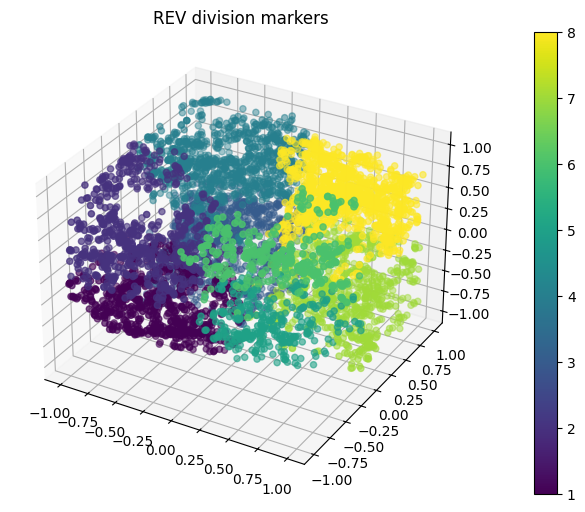

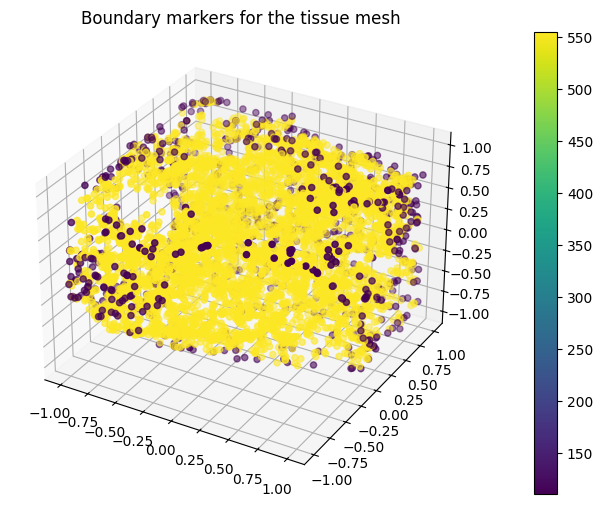

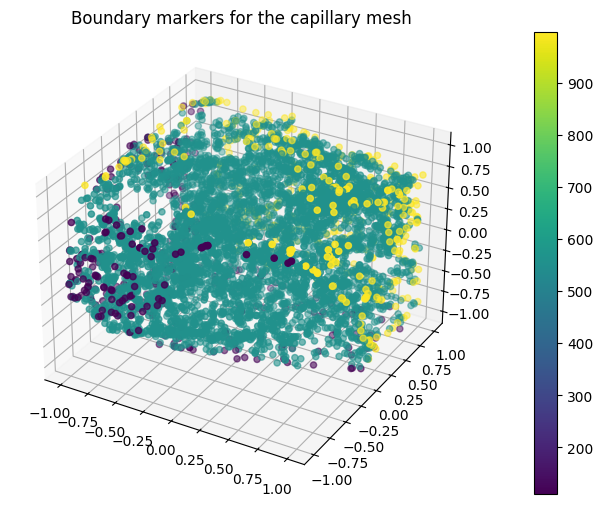

In [8]:
max_radius = 0.1
nn = 10

name_mesh="cube_tissue"
#--------------------------------------------------------------------

# # Get discrete system
start_time = time.time()
tag_in=111
tag_out=999
beta_value = 1e-6 # Neuman for tissue
p0_value=5000

nREV=8
coord=meshQ.coordinates()
create_mesh_Delaunay(name_mesh, coord)


meshV, Q_markers, V_markers, REV_markers_t = get_mesh(name_mesh,n_div_x,n_div_y,n_div_z)

tag_T=111

AD, M, b, W, T = get_system(meshV, K_x, K_y, K_z, C, mu_bl_up, beta_value,p0_value)


print("\n------------------ System setup and assembly time: ", time.time() - start_time, "\n")





Application of the Dirichlet boundary condition for the capillary

In [9]:
V = FunctionSpace(meshV, 'CG', 1)

bc_in = [DirichletBC(V, 7000, "on_boundary&&( (x[1]<-1+DOLFIN_EPS) || (x[0]<-1+DOLFIN_EPS) || (x[2]<-1+DOLFIN_EPS) )"),DirichletBC(V, 5000, "on_boundary&&( (x[1]>1-DOLFIN_EPS) || (x[0]>1-DOLFIN_EPS) || (x[2]>1-DOLFIN_EPS))")]


bcs = block_bc([bc_in, []], True)
bcs.apply(T).apply(b)


[[<dolfin.fem.dirichletbc.DirichletBC at 0x7faf009cedb0>,
 []]

Solving the Linear System

KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-15, absolute=1e-50, divergence=10000.
  right preconditioning
  using DEFAULT norm type for convergence test
PC Object: 1 MPI process
  type: ilu
  PC has not been set up so information may be incomplete
    out-of-place factorization
    0 levels of fill
    tolerance for zero pivot 2.22045e-14
    matrix ordering: natural
    matrix solver type: petsc
    matrix not yet factored; no additional information available
  linear system matrix = precond matrix:
  Mat Object: 1 MPI process
    type: seqaij
    rows=12252, cols=12252
    total: nonzeros=388824, allocated nonzeros=388824
    total number of mallocs used during MatSetValues calls=0
      not using I-node routines
iterations =  43
residual =  1.26e-10
converge reason =  2
re

Text(0.5, 0.92, 'Tissue Pressure (Pa)')

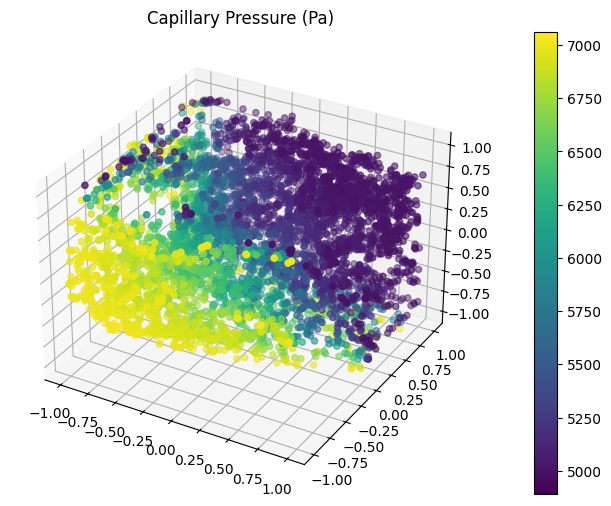

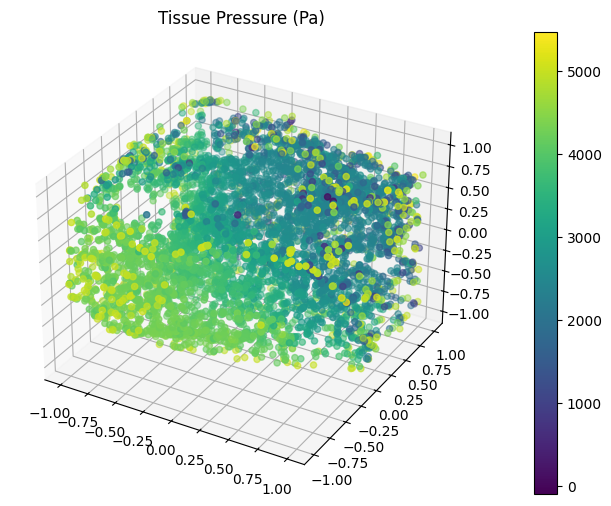

In [10]:

b_PET = ii_convert(b)
shape = b_PET.size()  
A_PET = ii_convert(T).mat()
b_PET = b_PET.vec()
u     = np.zeros((shape))
tol   = 1e-15
u_PET = PETSc.Vec().createWithArray(u)

# Create a PETSc Krylov solver
solver = PETSc.KSP().create()
solver.setOperators(A_PET)
solver.setType(PETSc.KSP.Type.GMRES)  # <--Choose the solver type
solver.setFromOptions()  # <--Allow setting options from the command line or a file
solver.setTolerances(rtol=tol)
solver.setPCSide(1)
solver.view()

# Set preconditioner
#pc = solver.getPC()
#pc.setType(PETSc.PC.Type.HYPRE)
#pc.setHYPREType("boomeramg")  # Set to use AMG
#pc.setType(PETSc.PC.Type.ILU)
#c.setType(PETSc.PC.Type.NONE)
#pc.setType(PETSc.PC.Type.JACOBI)


solver.solve(b_PET, u_PET)

# print
print ('iterations = ',               solver.getIterationNumber())
print ('residual = ', '{:.2e}'.format(solver.getResidualNorm()))#  %.2E
print ('converge reason = ',          solver.getConvergedReason())
print ('residuals at each iter = ',   solver.getConvergenceHistory())
#print ('precond type', pc.getType())
# Print solver information
num_iter = solver.getIterationNumber()
print(f"Number of iterations: {num_iter}")

print("\n------------------  System solved time: ", time.time() - start_time, "\n")


#Saving the results
Q = FunctionSpace(meshV, 'CG', 1)
dimQ= Q.dim()

pcap_pet_Q = u_PET[:dimQ]
pt_pet_Q = u_PET[dimQ:]

print(np.shape(pcap_pet_Q))
print(np.shape(pt_pet_Q))


p_cap=Function(Q)
p_t=Function(Q)


p_cap.vector()[:]=pcap_pet_Q
p_t.vector()[:]=pt_pet_Q
coord_V=meshV.coordinates()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=p_cap.compute_vertex_values(meshV))
cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
plt.title('Capillary Pressure (Pa)')

coord_V=meshV.coordinates()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter_plot=ax.scatter(coord_V[:,0],coord_V[:,1],coord_V[:,2],c=p_t.compute_vertex_values(meshV))
cbar = fig.colorbar(scatter_plot, ax=ax, pad=0.1)
plt.title('Tissue Pressure (Pa)')


In [11]:
#Saving

File(f'{dir_results}/FINAL_RESULTS/MARKERS/meshV.pvd') << meshV
File(f'{dir_results}/FINAL_RESULTS/PETSC/pcap_cube_case.pvd') << p_cap
File(f'{dir_results}/FINAL_RESULTS/PETSC/pt_cube_case.pvd') << p_t

SYNTHETIC NET ANALYSIS

This notebook is used to divide in a specific number of REV the synthetic cubic network given as input, to compute the upscaled parameters and to solve the final coupled problem.

SYNTHETIC NET ANALYSIS

This notebook is used to divide in a specific number of REV the synthetic cubic network given as input, to compute the upscaled parameters and to solve the final coupled problem.